# Interrupted Time Series Analysis - 使用例

このノートブックでは、`its_analysis`パッケージを使用した断続的時系列分析の例を示します。

## 📚 カバーする内容

1. **OLSモデル**: 複数グループ・複数介入に対応した基本的な線形回帰モデル
2. **SARIMAXモデル**: 自己相関と移動平均を考慮した時系列モデル
3. **Prophetモデル**: Facebookが開発したトレンドと季節性を柔軟にモデル化できるモデル
4. **Markdownレポート生成**: 分析結果を包括的なレポートとして出力

## 基本的な考え

$$
y_t = \beta_0 + \beta_1 t + \beta_2 D_t + \beta_3 \Delta_t + \sum_{j=1}^{p} \eta_j X_{j,t} +\epsilon_j
$$

ここで、
- $y_t$: 時点 $t$ におけるアウトカム
- $t$: 時点
- $D_t$: 介入が行われた後の時点では1、それ以前の時点では0
- $\Delta_t$: 介入後の時点における時間の経過を表す
- $X_{j,t}$: 共変量
- $\epsilon_t$: 誤差項

## セットアップ

必要なライブラリとモジュールをインポートします。

In [9]:
from module.its_analysis import (
    ITSDataPreprocessor,
    ITSModelOLS,
    ITSModelSARIMAX,
    ITSModelProphet,
    ITSVisualizer
)
from module import generate_markdown_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
from pathlib import Path

# モジュールのインポートパス設定
sys.path.insert(0, str(Path.cwd().parent / 'src'))

print("✅ インポート完了")

✅ インポート完了


## データの準備

Cigarデータセット（たばこ販売データ）を使用します。
- **state**: 州ID
- **year**: 年
- **sales**: たばこ販売量（アウトカム変数）
- **price**: たばこ価格（共変量）
- **pop**: 人口（共変量）

In [10]:
# Cigarデータセットの読み込み
cigar = sm.datasets.get_rdataset("Cigar", "Ecdat").data

# 使用するデータの準備
state = [3, 5]
timestamp = [75, 80, 85]  # 複数の介入ポイント

# サブセットを作成
usecols = ['state', 'year', 'price', 'pop', 'sales']
cigar_model = cigar.loc[(cigar['state'].isin(state)) &
                        (cigar['year'] >= 65), usecols].copy()

print(f"データ形状: {cigar_model.shape}")
print(f"\n最初の5行:")
cigar_model.head()

データ形状: (56, 5)

最初の5行:


,state,year,price,pop,sales
32,3,65,24.2,1575.0,123.2
33,3,66,29.6,1609.0,113.9
34,3,67,29.2,1637.0,117.1
35,3,68,31.3,1667.0,115.6
36,3,69,36.1,1693.0,113.8


---

## 1. OLSモデルによる複数介入分析

最も基本的な線形回帰モデルで、複数のグループと複数の介入ポイントに対応しています。

In [11]:
print("=" * 80)
print("1. OLSモデルによる複数介入分析")
print("=" * 80)

model_ols = ITSModelOLS(
    time_column='year',
    intervention_points=timestamp,
    group_column='state'
)

# モデルのフィッティング
model_ols.fit(cigar_model, target_column='sales', covariates=['price', 'pop'])

print("✅ OLSモデルのフィッティング完了")

1. OLSモデルによる複数介入分析
✅ OLSモデルのフィッティング完了


### 介入効果の確認

`calculate_intervention_effect()`メソッドは、期間別に集約された介入効果を返します。

In [12]:
# 介入効果のDataFrame出力
effect_df = model_ols.calculate_intervention_effect()
print("\n介入効果DataFrame:")
effect_df


介入効果DataFrame:


,state,Period,Actual_mean,Predicted_mean,Counterfactual_mean,Effect_mean
0,3,Intervention_D_1,123.0200,124.072986,120.525234,2.494766
1,3,Intervention_D_2,114.4600,114.012932,114.757661,-0.297661
2,3,Intervention_D_3,96.1500,92.469182,99.461268,-3.311268
3,3,Pre-intervention,119.4800,123.372945,123.372945,-3.892945
4,5,Intervention_D_1,125.9000,124.847014,121.299263,4.600737
5,5,Intervention_D_2,113.9600,114.407068,115.151797,-1.191797
6,5,Intervention_D_3,85.8125,89.493318,96.485405,-10.672905
7,5,Pre-intervention,127.9400,124.047055,124.047055,3.892945


In [13]:
# 各期間の平均効果を詳細表示
print("\n各期間の平均効果:")
for period in effect_df['Period'].unique():
    if period != 'Pre-intervention':
        period_data = effect_df[effect_df['Period'] == period]
        if 'state' in period_data.columns:
            # state別に集計
            for state_val in period_data['state'].unique():
                state_data = period_data[period_data['state'] == state_val]
                print(f"  state={state_val}, {period}: "
                      f"Actual_mean={state_data['Actual_mean'].values[0]:.2f}, "
                      f"Counterfactual_mean={state_data['Counterfactual_mean'].values[0]:.2f}, "
                      f"Effect_mean={state_data['Effect_mean'].values[0]:.2f}")
        else:
            print(f"  {period}: "
                  f"Actual_mean={period_data['Actual_mean'].values[0]:.2f}, "
                  f"Counterfactual_mean={period_data['Counterfactual_mean'].values[0]:.2f}, "
                  f"Effect_mean={period_data['Effect_mean'].values[0]:.2f}")


各期間の平均効果:
  state=3, Intervention_D_1: Actual_mean=123.02, Counterfactual_mean=120.53, Effect_mean=2.49
  state=5, Intervention_D_1: Actual_mean=125.90, Counterfactual_mean=121.30, Effect_mean=4.60
  state=3, Intervention_D_2: Actual_mean=114.46, Counterfactual_mean=114.76, Effect_mean=-0.30
  state=5, Intervention_D_2: Actual_mean=113.96, Counterfactual_mean=115.15, Effect_mean=-1.19
  state=3, Intervention_D_3: Actual_mean=96.15, Counterfactual_mean=99.46, Effect_mean=-3.31
  state=5, Intervention_D_3: Actual_mean=85.81, Counterfactual_mean=96.49, Effect_mean=-10.67


### 可視化

図を保存しました: output/example_ols_multiple_interventions.png


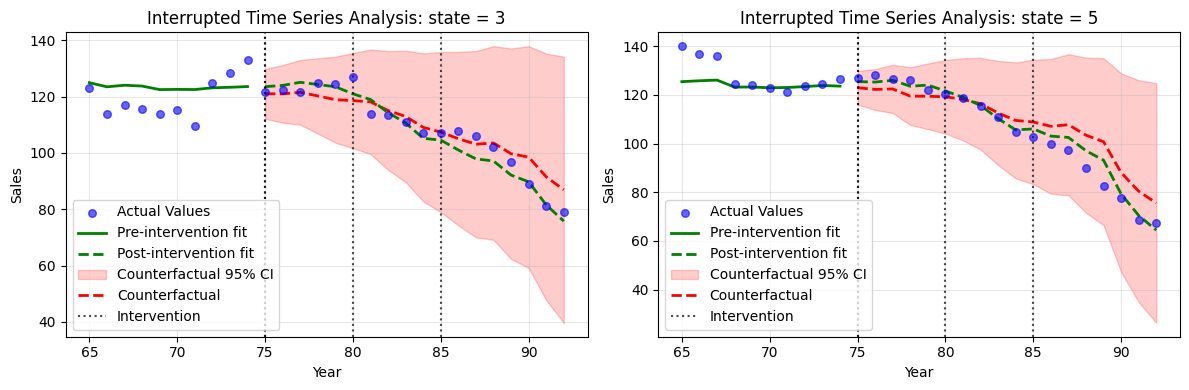


✅ 可視化を保存しました: output/example_ols_multiple_interventions.png


In [14]:
# 可視化
visualizer = ITSVisualizer(model_ols)
fig = visualizer.plot(save_path='output/example_ols_multiple_interventions.png')
plt.show()
print("\n✅ 可視化を保存しました: output/example_ols_multiple_interventions.png")

---

## 2. SARIMAXモデルによる分析

自己相関と移動平均を考慮したSARIMAXモデルを使用します。
ここでは単一グループ（state=3のみ）で分析します。

In [15]:
print("=" * 80)
print("2. SARIMAXモデルによる分析（state=3のみ）")
print("=" * 80)

cigar_single = cigar_model[cigar_model['state'] == 3].copy()

model_sarimax = ITSModelSARIMAX(
    time_column='year',
    intervention_points=timestamp
)

# モデルのフィッティング（Optunaチューニングは時間がかかるのでスキップ）
model_sarimax.fit(cigar_single, target_column='sales', order=(1, 0, 1))

print("✅ SARIMAXモデルのフィッティング完了")

2. SARIMAXモデルによる分析（state=3のみ）
✅ SARIMAXモデルのフィッティング完了


In [23]:
# 介入効果
effect_df_sarimax = model_sarimax.calculate_intervention_effect()
print("\n介入効果DataFrame:")
effect_df_sarimax


介入効果DataFrame:


,Period,Actual_mean,Predicted_mean,Counterfactual_mean,Effect_mean
0,Intervention_D_1,123.02,124.398421,80.393245,42.626755
1,Intervention_D_2,114.46,121.204112,79.264998,35.195002
2,Intervention_D_3,96.15,96.051117,77.822927,18.327073
3,Pre-intervention,119.48,105.971312,82.117848,37.362152


In [5]:
# 可視化
visualizer_sarimax = ITSVisualizer(model_sarimax)
fig = visualizer_sarimax.plot(save_path='output/example_sarimax.png')
plt.show()
print("\n✅ 可視化を保存しました: output/example_sarimax.png")

NameError: name 'model_sarimax' is not defined

---

## 3. Prophetモデルによる分析

Facebook Prophetを使用した時系列分析です。
トレンドと季節性を柔軟にモデル化できます。

In [6]:
print("=" * 80)
print("3. Prophetモデルによる分析（state=3のみ）")
print("=" * 80)

model_prophet = ITSModelProphet(
    time_column='year',
    intervention_points=timestamp
)

# モデルのフィッティング
model_prophet.fit(cigar_single, target_column='sales')

print("✅ Prophetモデルのフィッティング完了")

3. Prophetモデルによる分析（state=3のみ）


NameError: name 'timestamp' is not defined

In [7]:
# 介入効果
effect_df_prophet = model_prophet.calculate_intervention_effect()
print("\n介入効果DataFrame:")
effect_df_prophet

NameError: name 'model_prophet' is not defined

In [8]:
# 可視化
visualizer_prophet = ITSVisualizer(model_prophet)
fig = visualizer_prophet.plot(save_path='output/example_prophet.png')
plt.show()
print("\n✅ 可視化を保存しました: output/example_prophet.png")

NameError: name 'model_prophet' is not defined

---

## 4. Markdownレポートの生成

すべての分析結果を包括的なMarkdownレポートとして出力します。

In [ ]:
print("=" * 80)
print("4. Markdownレポートの生成")
print("=" * 80)
print("📝 分析結果をMarkdownレポートにまとめています...")

try:
    report_path = generate_markdown_report(output_path='output/analysis_report.md')
    print(f"✅ レポート生成完了: {report_path}")
    print("🔍 レポートをMarkdownビューアーで確認してください！")
    print("\nレポートには以下が含まれています:")
    print("  - データ概要")
    print("  - OLSモデル分析結果")
    print("  - SARIMAXモデル分析結果")
    print("  - Prophetモデル分析結果")
    print("  - モデル間の比較表")
    print("  - 可視化グラフ")
except Exception as e:
    print(f"❌ レポート生成中にエラーが発生しました: {e}")